In [1]:
import os
import pickle
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
import tensorflow as tf
# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime
tf.__version__ # printint out tensorflow version used
import stable_baselines3
import sb3_contrib
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.results_plotter import load_results, ts2xy
from stable_baselines3.common.results_plotter import load_results, ts2xy
import optuna
# from stable_baselines3.bench import Monitor
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common import results_plotter
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
#stable_baselines.__version__ # printing out stable_baselines version used
import gym
import pickle
import cProfile 
import pandas as pd
import ast
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 11}
matplotlib.rc('font', **font)

In [22]:
current_directory = os.getcwd()

exp_id = "2022-03-09v7nsfU100Grewm1R3"
eval_name = "_no_tfb"
# eval_name = "_tfb_2500"
# eval_name = ""
route_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"
eval_dir = route_dir+exp_id+"/_core_0/eval_results"+eval_name
# "GRAVITY" NSFNET 
# eval_dir_h = route_dir+"2022-02-23v42nsftfb"+"/_core_0/eval_results"+"_tfb"
# eval_dir_h = route_dir+"2022-02-23v42nsftfbR3"+"/_core_0/eval_results"+"_no_tfb"
# eval_dir_h = route_dir+"2022-02-24nsfgravityk3heuristics_eval/eval_results_no_tfb"

# UNIFORM NSFNET
# eval_dir_h = route_dir+"2022-02-24nsfnotfbuniheuristics_eval/eval_results_no_tfb"  # 100G, k=5, 10k requests

# eval_dir_h = route_dir+"2022-02-24nsfunik3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-01nsfuni200Gk3heuristics_eval/eval_results_no_tfb"
# eval_dir_h = route_dir+"2022-03-03nsfuni500G2kRk5heuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

# UNIFORM 50% perturbation NSFNET
eval_dir_h = route_dir+"2022-03-04nsfUp50100G10kRheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests

# eval_dir_h = route_dir+"2022-03-04nsfUp50500G2kRheuristics_eval/eval_results_no_tfb" 

# UNIFORM DTAG
# eval_dir_h = route_dir+"2022-02-24dtagnotfbuniheuristics_eval/eval_results_no_tfb" # 100G, k=5, 10k requests
# eval_dir_h = route_dir+"2022-02-24dtagunik3heuristics_eval/eval_results_no_tfb"  # 100G, k=3, 10k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gheuristics_eval/eval_results_no_tfb"  # 200G, k=5, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200Gk3heuristics_eval/eval_results_no_tfb" # 200G, k=3, 5k requests
# eval_dir_h = route_dir+"2022-03-01dtaguni200G75kRk3heuristics_eval/eval_results_no_tfb" # 200G, k=5, 7.5k requests
# UNIFORM 50% perturbation DTAG
# eval_dir_h = route_dir+"2022-03-04dtagUp50500G2kRheuristics_eval/eval_results_no_tfb" # 500G, k=5, 2k requests 

In [37]:
def get_info(eval_dir, model, get_dist):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
    eval_eps = df.index.values
    rewards = df['r'].to_numpy()
    sim_time = df['t'].to_numpy()
    services_accepted_ep = df['episode_services_accepted'].to_numpy()
    services_processed_ep = df['episode_services_processed'].to_numpy()
    services_accepted = df['services_accepted'].to_numpy()
    services_processed = df['services_processed'].to_numpy()
    throughput = df['throughput']/1e12
    if get_dist:
        service_dist = df['service_distribution']
#         service_dist = service_dist[0]
#         service_dist = ast.literal_eval(service_dist)
#         service_dist = np.array(service_dist).reshape(22,100)  # NOTE! HAVE HARD CODED NUMBER OF EDGES AND CHANNELS!
    #cum_services_accepted_ep = df['episode_cum_services_accepted']
    #     return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput, service_dist
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput, service_dist
    else:
        return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput
def get_cum_results(eval_dir, model):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
    cum_services_accepted = df['episode_cum_services_accepted'].to_numpy()
    cum_services_processed = df['episode_cum_services_processed'].to_numpy()
    return cum_services_accepted, cum_services_processed
def get_services(service_dist, iter):
    service_dist = service_dist[0]
    service_dist = ast.literal_eval(service_dist)
    service_dist = np.array(service_dist).reshape(22,100)  # NOTE! HAVE HARD CODED NUMBER OF EDGES AND CHANNELS!
    return service_dist

In [38]:
# tfb_test = pickle.load(open(eval_dir+"/tfb_test.pkl",'rb'))
# tfb_test

In [40]:
rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl, service_dist_rl = get_info(eval_dir, 'rl', True)
# rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl = get_info(eval_dir, 'rl', False)

# rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl, service_dist_rl = get_info(eval_dir, 'rl')
rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff = get_info(eval_dir_h, 'kspff', False)
rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp = get_info(eval_dir_h, 'ffksp', False)
rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu = get_info(eval_dir_h, 'camu', False)
rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu = get_info(eval_dir_h, 'kspmu', False)

In [15]:
# service_dist_rl[0]
# cum_services_accepted_rl, cum_services_processed_rl = get_cum_results(eval_dir, 'rl')
# test = ast.literal_eval(cum_services_accepted_rl[0])
# test2 = ast.literal_eval(cum_services_processed_rl[0])

In [16]:
pickle.dump(np.mean(services_accepted_ep_rl), open("results/"+exp_id+"_mean.pkl",'wb'))
pickle.dump(np.median(services_accepted_ep_rl), open("results/"+exp_id+"_median.pkl",'wb'))
pickle.dump(np.std(services_accepted_ep_rl), open("results/"+exp_id+"_std.pkl",'wb'))

In [17]:
print("Mean:",np.mean(services_accepted_ep_rl))
print("Median:",np.median(services_accepted_ep_rl))
print("Std:",np.std(services_accepted_ep_rl))

Mean: 6850.27
Median: 6849.0
Std: 63.44507151859788


In [9]:
print("RL:",np.mean(services_accepted_ep_rl))
print("kSP-FF:",np.mean(services_accepted_ep_kspff))
print("FF-kSP:",np.mean(services_accepted_ep_ffksp))
print("CA-MU:",np.mean(services_accepted_ep_camu))
print("kSP-MU:",np.mean(services_accepted_ep_kspmu))

RL: 6802.24
kSP-FF: 6701.0
FF-kSP: 6819.64
CA-MU: 6652.92
kSP-MU: 6805.04


In [10]:
print("RL:",np.median(services_accepted_ep_rl))
print("kSP-FF:",np.median(services_accepted_ep_kspff))
print("FF-kSP:",np.median(services_accepted_ep_ffksp))
print("CA-MU:",np.median(services_accepted_ep_camu))
print("kSP-MU:",np.median(services_accepted_ep_kspmu))

RL: 6795.5
kSP-FF: 6710.0
FF-kSP: 6818.0
CA-MU: 6664.5
kSP-MU: 6801.5


In [ ]:
print("RL:",np.std(services_accepted_ep_rl))
print("kSP-FF:",np.std(services_accepted_ep_kspff))
print("FF-kSP:",np.std(services_accepted_ep_ffksp))
print("CA-MU:",np.std(services_accepted_ep_camu))
print("kSP-MU:",np.std(services_accepted_ep_kspmu))

In [ ]:
print("RL:",np.mean(rewards_rl))
print("kSP-FF:",np.mean(rewards_kspff))
print("FF-kSP:",np.mean(rewards_ffksp))
print("CA-MU:",np.mean(rewards_camu))
print("kSP-MU:",np.mean(rewards_kspmu))

In [ ]:
np.mean(services_accepted_ep_rl) - np.mean(services_accepted_ffksp)

In [ ]:
f, ax = plt.subplots()
dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
#dict_plt = {'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.ylim([2285, 2305])
plt.grid()
plt.savefig('figures/'+exp_id+eval_name+'boxplot.jpeg', dpi=300,bbox_inches='tight')
plt.show()

Service distribution stuff!

In [52]:
service_dist = get_services(service_dist_rl, 0)

Occpuation of each wavelength slot

In [63]:
channel_occ = np.sum(service_dist, axis=0)
channel_occ

array([148, 152, 146, 174, 180, 145, 172, 114, 120, 138, 146, 136, 182,
       148, 139, 151, 160, 116, 138, 137, 210, 168, 218, 148, 191, 126,
       158, 157, 120, 188, 186, 173, 212, 190, 193, 139, 147, 146, 148,
       134, 130, 156, 175, 146, 155, 133, 122, 108, 165, 129, 137, 155,
       149, 161, 197, 192, 128, 129, 133, 129, 179, 112, 166, 169, 146,
       164, 144, 112, 153, 148, 151, 140, 168, 194, 175, 132, 145, 152,
       141, 129, 123, 159, 121, 129, 127, 174, 134, 153, 152, 133, 164,
       136, 175, 152, 152, 132, 144, 166, 130, 204])

In [68]:
np.argsort(channel_occ)[::-1]

array([22, 32, 20, 99, 54, 73, 34, 55, 24, 33, 29, 30, 12,  4, 60, 42, 74,
       92,  3, 85, 31,  6, 63, 21, 72, 97, 62, 48, 65, 90, 53, 16, 81, 26,
       27, 41, 44, 51, 87, 68,  1, 77, 88, 93, 94, 70, 15, 52, 38, 23, 13,
        0, 69, 36, 64, 10, 43,  2, 37, 76,  5, 96, 66, 78, 71, 14, 35,  9,
       18, 50, 19, 11, 91, 86, 39, 45, 89, 58, 75, 95, 40, 98, 83, 49, 79,
       59, 57, 56, 84, 25, 80, 46, 82,  8, 28, 17,  7, 67, 61, 47])

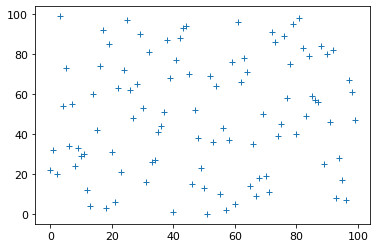

In [70]:
plt.plot(np.argsort(channel_occ)[::-1], "+")
plt.show()

Occupation of each edge

In [64]:
edge_occ =np.sum(service_dist, axis=1)
edge_occ

array([443, 377, 605, 497, 750, 695, 741, 734, 667, 833, 747, 726, 791,
       602, 808, 837, 826, 750, 770, 591, 563, 850])

Most to least occupied edges:

In [67]:
np.argsort(edge_occ)[::-1]

array([21, 15,  9, 16, 14, 12, 18,  4, 17, 10,  6,  7, 11,  5,  8,  2, 13,
       19, 20,  3,  0,  1])

Mapping of topology to edge indices:  
1 2 1000 --> 0  
1 3 1500 --> 1  
1 8 2400 --> 2  
2 3 600  --> 3  
2 4 700  --> 4  
3 6 1800 --> 5  
4 5 600  --> 6  
4 11 1900--> 7  
5 6 1200 --> 8  
5 7 600  --> 9  
6 10 1000--> 10  
6 14 1800--> 11  
7 8 700  --> 12  
7 10 1300--> 13  
8 9 700  --> 14  
9 10 700 --> 15  
9 12 300 --> 16  
9 13 300 --> 17   
11 12 600--> 18  
11 13 700--> 19  
12 14 300--> 20  
13 14 100--> 21  

Calculate average over multiple runs

In [ ]:
exp_id_r1 = "2022-03-07v7nsfU100G"
exp_id_r2 = "2022-03-07v7nsfU100GR2"
exp_id_r3 = "2022-03-07v7nsfU100GR3"
exp_id_r4 = "2022-03-07v7nsfU100GR4"
exp_id_r5 = "2022-03-07v7nsfU100GR5"

R1_mean = pickle.load(open("results/"+exp_id_r1+"_mean.pkl",'rb'))
R2_mean = pickle.load(open("results/"+exp_id_r2+"_mean.pkl",'rb'))
R3_mean = pickle.load(open("results/"+exp_id_r3+"_mean.pkl",'rb'))
R4_mean = pickle.load(open("results/"+exp_id_r4+"_mean.pkl",'rb'))
# R5_mean = pickle.load(open("results/"+exp_id_r5+"_mean.pkl",'rb'))
ave_mean = np.mean([R1_mean,R2_mean,R3_mean,R4_mean])
R1_median = pickle.load(open("results/"+exp_id_r1+"_median.pkl",'rb'))
R2_median = pickle.load(open("results/"+exp_id_r2+"_median.pkl",'rb'))
R3_median = pickle.load(open("results/"+exp_id_r3+"_median.pkl",'rb'))
R4_median = pickle.load(open("results/"+exp_id_r4+"_median.pkl",'rb'))
# R5_median = pickle.load(open("results/"+exp_id_r5+"_median.pkl",'rb'))
ave_median = np.mean([R1_median,R2_median,R3_median,R4_median])
R1_std = pickle.load(open("results/"+exp_id_r1+"_std.pkl",'rb'))
R2_std = pickle.load(open("results/"+exp_id_r2+"_std.pkl",'rb'))
R3_std = pickle.load(open("results/"+exp_id_r3+"_std.pkl",'rb'))
R4_std = pickle.load(open("results/"+exp_id_r4+"_std.pkl",'rb'))
# R5_std = pickle.load(open("results/"+exp_id_r5+"_std.pkl",'rb'))
ave_std = np.mean([R1_std,R2_std,R3_std,R4_std])

In [ ]:
print("Mean:",ave_mean)
print("Median:",ave_median)
print("Std:",ave_std)

In [ ]:
f, ax = plt.subplots()
dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
#dict_plt = {'FF-kSP':services_accepted_ep_ffksp, 'RL':services_accepted_ep_rl}
plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.ylim([2285, 2305])
plt.grid()
# plt.savefig('figures/'+exp_id+eval_name+'boxplot.jpeg', dpi=300,bbox_inches='tight')
plt.show()

Plotting for multiple RL agents:

In [ ]:
# exp_id_1 = "2022-02-03v42frR3"  # old top best res
# exp_id_2 = "2022-02-04v2112frR3cont" # old top with v2112 bug best res

# exp_id_1 = "2022-02-08v42frfixedrdR2"  # best res with rounded NSFNET and v2112 fixed tfb = false training
# exp_id_2 = "2022-02-09v2112frfixedrdcont"

# exp_id_4 = "2022-02-09v2112tfbnsf"


exp_id_1 = "2022-02-09v42tfbnsfR2"  # best res with rounded NSFNET and v2112 fixed tfb = True training
exp_id_h = "2022-02-08v42frfixedrd"  # NSFNET

# exp_id_1 = "2022-02-09v42frfixeddtagcont"  # best res with DTAG and v2112 fixed tfb = false training
# exp_id_2 = "2022-02-08v2112frfixeddtagR2"
# # exp_id_2 = "2022-02-09v2112tfbdtagR3"


# exp_id_1 = "2022-02-09v42tfbdtagR3"  # best res with DTAG and v2112 fixed tfb = True training
# exp_id_h = "2022-02-08v42frfixeddtagR3" # DTAG

# exp_id_3 = "2022-02-09v42frfixeddtagcont"  # best res with DTAG and v2112 fixed tfb = false training
# exp_id_4 = "2022-02-08v2112frfixeddtagR2"

eval_name_plot = "_tfb_2500"
eval_dir_1 = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id_1+"/_core_0/eval_results"+eval_name_plot
# eval_dir_2 = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id_2+"/_core_0/eval_results"+eval_name_plot
# eval_dir_3 = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id_3+"/_core_0/eval_results"+eval_name_plot
# eval_dir_4 = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id_4+"/_core_0/eval_results"+eval_name_plot
eval_dir_h = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id_h+"/_core_0/eval_results"+eval_name_plot

In [ ]:
rewards_rl_1, eval_eps_rl_1, sim_time_rl_1, services_accepted_ep_rl_1, services_processed_ep_rl_1, services_accepted_rl_1, services_processed_rl_1, throughput_rl_1 = get_info(eval_dir_1, 'rl')
# rewards_rl_2, eval_eps_rl_2, sim_time_rl_2, services_accepted_ep_rl_2, services_processed_ep_rl_2, services_accepted_rl_2, services_processed_rl_2, throughput_rl_2 = get_info(eval_dir_2, 'rl')
# rewards_rl_3, eval_eps_rl_3, sim_time_rl_3, services_accepted_ep_rl_3, services_processed_ep_rl_3, services_accepted_rl_3, services_processed_rl_3, throughput_rl_3 = get_info(eval_dir_3, 'rl')
# rewards_rl_4, eval_eps_rl_4, sim_time_rl_4, services_accepted_ep_rl_4, services_processed_ep_rl_4, services_accepted_rl_4, services_processed_rl_4, throughput_rl_4 = get_info(eval_dir_4, 'rl')

# rewards_rl_3, eval_eps_rl_3, sim_time_rl_3, services_accepted_ep_rl_3, services_processed_ep_rl_3, services_accepted_rl_3, services_processed_rl_3, throughput_rl_3 = get_info(eval_dir_3, 'rl')
rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff = get_info(eval_dir_h, 'kspff')
rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp = get_info(eval_dir_h, 'ffksp')
rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu = get_info(eval_dir_h, 'camu')
rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu = get_info(eval_dir_h, 'kspmu')

In [ ]:
topology = 'nsfnet'
f, ax = plt.subplots()
bp = dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,
            'RL':services_accepted_ep_rl_1}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.legend([bp["boxes"][0]], ['A'], loc='upper right')
plt.grid()
#plt.savefig('figures/servicesaccepted_bestresults'+topology+eval_name_plot+'modelA.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
topology = 'dtag'
f, ax = plt.subplots()
bp = dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,
            'RL':services_accepted_ep_rl_1, 'RL-TFB':services_accepted_ep_rl_2}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.legend([bp["boxes"][0]], ['A'], loc='upper right')
plt.grid()
plt.savefig('figures/servicesaccepted_bestresults'+topology+eval_name_plot+'besttraintypes.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
topology = 'dtag'
f, ax = plt.subplots()
bp = dict_plt = {'kSP-FF':services_accepted_ep_kspff,'kSP-MU':services_accepted_ep_kspmu,'FF-kSP':services_accepted_ep_ffksp,
            'A':services_accepted_ep_rl_1, 'B':services_accepted_ep_rl_2,
                'A TFB':services_accepted_ep_rl_3, 'B TFB':services_accepted_ep_rl_4}
bp = plt.boxplot(dict_plt.values(),showfliers=False,showmeans=True)
ax.set_xticklabels(dict_plt.keys())
plt.ylabel("Services accepted")
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
# plt.legend([bp["boxes"][0]], ['A'], loc='upper right')
plt.grid()
#plt.savefig('figures/servicesaccepted_bestresults'+topology+eval_name+'bothtraintypes.png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
medians = [item.get_ydata()[0] for item in bp['medians']]
means = [item.get_ydata()[0] for item in bp['means']]
print(f'Medians: {medians}\n'
      f'Means:   {means}')

In [ ]:
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print(f'Minimums: {minimums}\n'
      f'Maximums: {maximums}')

In [ ]:
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
# print(f'Q1: {q1}\n'
#       f'Q3: {q3}')
IQR = [q3[i] - q1[i] for i in range(len(q1))]
print(IQR)

In [ ]:
print("RL A:",np.std(services_accepted_ep_rl_1))
print("RL B:",np.std(services_accepted_ep_rl_2))
print("RL A TFB:",np.std(services_accepted_ep_rl_3))
print("RL B TFB:",np.std(services_accepted_ep_rl_4))

In [ ]:
print("kSP-FF:",np.std(services_accepted_ep_kspff))
print("FF-kSP:",np.std(services_accepted_ep_ffksp))
print("CA-MU:",np.std(services_accepted_ep_camu))
print("kSP-MU:",np.std(services_accepted_ep_kspmu))

In [ ]:
print("RL:",np.mean(services_accepted_ep_rl) + np.std(services_accepted_ep_rl))
print("kSP-FF:",np.mean(services_accepted_ep_kspff) +np.std(services_accepted_ep_kspff))
print("FF-kSP:",np.mean(services_accepted_ep_ffksp) +np.std(services_accepted_ep_ffksp))
print("CA-MU:",np.mean(services_accepted_ep_camu) +np.std(services_accepted_ep_camu))
print("kSP-MU:",np.mean(services_accepted_ep_kspmu) +np.std(services_accepted_ep_kspmu))

In [ ]:
100*(2159-2151)/2159

In [ ]:
100*(2156-2151)/2156

In [ ]:
((341-21)/2156)*100

In [ ]:
((2158-2099)/2099)*100

In [ ]:
((2151-2092)*25)/1000

In [ ]:
2151-2099

In [ ]:
((2151-2099)*25)/1000

In [ ]:
((3416-3256)*25)/1000

In [ ]:
((3416-3256)/3256)*100

In [ ]:
3416-3256

In [ ]:
((2158-2156)/2156)*100

In [ ]:
y_max = 25
f, ax = plt.subplots()
plt.hist(services_accepted_ep_kspff, label='kSP-FF')
plt.hist(services_accepted_ep_camu, label='CA-MU')
plt.hist(services_accepted_ep_kspmu, label='kSP-MU')
plt.hist(services_accepted_ep_ffksp, label='FF-kSP')
plt.hist(services_accepted_ep_rl, label='RL')
plt.vlines(np.mean(services_accepted_ep_rl), 0, y_max, color='k',linestyles='--', label='RL mean')
plt.vlines(np.mean(services_accepted_ep_ffksp), 0, y_max, color='k',linestyles='-.', label='FF-kSP mean')
plt.xlabel("Services accepted")
plt.ylabel("Frequency density")
plt.ylim([0,y_max])
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.legend(ncol = 2,loc='upper center', prop = {'size':10})
# plt.savefig('figures/servicesacceptedv2111f25Gbid.jpeg', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(eval_eps_kspff, throughput_kspff, '+', label='kSP-FF')
plt.plot(eval_eps_ffksp, throughput_ffksp, '+', label='FF-kSP')
plt.plot(eval_eps_camu, throughput_camu, '+', label='CA-MU')
plt.plot(eval_eps_kspmu, throughput_kspmu, '+', label='kSP-MU')
plt.plot(eval_eps_rl, throughput_rl, '+', label='RL')
plt.xlabel("Evaluation episodes")
plt.ylabel("Throughput")
plt.legend()
plt.show()

In [ ]:
plt.plot(eval_eps_kspff, services_accepted_ep_kspff, 'rx', label='kSP-FF')
# plt.plot(eval_eps_ffksp, services_accepted_ep_ffksp, 'rP', label='FF-kSP')
# plt.plot(eval_eps_camu, services_accepted_ep_camu, 'k.', label='CA-MU')
# plt.plot(eval_eps_kspmu, services_accepted_ep_kspmu, 'm*', label='kSP-MU')
plt.plot(eval_eps_rl, services_accepted_ep_rl, 'b-', label='RL')
plt.xlabel("Evaluation episodes")
plt.ylabel("Services accepted")
plt.legend()
plt.show()

Timing results

In [ ]:
rl_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_RL.pkl", 'rb'))
kspff_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspff.pkl", 'rb'))
ffksp_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_ffksp.pkl", 'rb'))
camu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_camu.pkl", 'rb'))
kspmu_time = pickle.load(open("/Users/joshnevin/RL_FOCSLab/eval_timing/"+exp_id+"_kspmu.pkl", 'rb'))

In [ ]:
print(rl_time)
print(kspff_time)
print(ffksp_time)
print(camu_time)
print(kspmu_time)